In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import clear_output
! pip install ./drive/MyDrive/RecNN
! pip install gdown
clear_output()

In [3]:
! pip install torch_optimizer
clear_output()

## Downloading dataset

In [4]:
! wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
! gdown https://drive.google.com/uc?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
! unzip ml-20m.zip
clear_output()

In [5]:
import numpy as np
import pandas as pd
import json

In [6]:
from pandas.plotting import table
import subprocess
from scipy.spatial import distance

In [7]:
pd.read_csv('/content/ml-20m/genome-scores.csv').head(5)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [8]:
pd.read_csv('/content/ml-20m/genome-tags.csv').head(5)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [9]:
pd.read_csv('/content/ml-20m/links.csv').head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
pd.read_csv('/content/ml-20m/movies.csv').head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
pd.read_csv('/content/ml-20m/ratings.csv').head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [12]:
n = pd.read_csv('/content/ml-20m/ratings.csv')

In [13]:
n.rating.max()

5.0

In [14]:
pd.read_csv('/content/ml-20m/tags.csv').head(5)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


## Environment

In [15]:
from IPython.display import clear_output
import recnn
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch_optimizer as optim

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [115]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="",
    embeddings="ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cached_frame_env.pkl", 
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

Getting train and test batches from the environmnent

In [116]:
train = env.train_batch()
test = env.test_batch()
state, action, reward, next_state, done = recnn.data.get_base_batch(train, device=torch.device('cpu'))

Metadata:
    user ids and their positions

In [18]:
train['meta']

{'sizes': tensor([609,  23,  20,  47,  67, 475,  20,  26,  65, 176,  26, 157, 235,  94,
          29,  47,  62, 202,  21, 146, 155,  58, 147,  23,  27]),
 'users': tensor([ 46436, 131689, 103564,  64312,  21645, 114300,  77510,   2385,  75547,
         111802,  80132,  89199,  35592,  14582,  18281,  34932, 102209,  96144,
           3337,  50216, 116045,  92156,  45886,  66896,  84206])}

## Working with metadata
user_id: their item/rating positions in the batch

In [117]:
user_ends = np.cumsum(train['meta']['sizes']).numpy().tolist() + [0]
user_starts = [0] + user_ends
starts_ends = list(zip(user_starts, user_ends))[:-1]
user_range = dict(zip(train['meta']['users'].numpy(), starts_ends))
user_range

{660: (527, 562),
 29292: (2658, 3120),
 33544: (1926, 2056),
 35535: (262, 315),
 44197: (373, 484),
 55124: (562, 602),
 59457: (602, 1694),
 66117: (2056, 2236),
 69063: (1694, 1836),
 70072: (2236, 2563),
 74581: (0, 20),
 79385: (124, 150),
 80273: (3120, 3143),
 83967: (2619, 2658),
 84729: (20, 72),
 90345: (1892, 1926),
 97951: (1836, 1867),
 114351: (3143, 3201),
 117815: (72, 124),
 120282: (2563, 2619),
 121145: (150, 262),
 129899: (484, 527),
 131073: (315, 338),
 134908: (338, 373),
 135345: (1867, 1892)}

## Recommending
Let's initialize main networks, and do recommendations

In [118]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

In [119]:
recommendation = policy_net(state)
value = value_net(state, recommendation)
print(recommendation)
print(value)

tensor([[-1.3052, -6.6150, -0.4931,  ..., -3.7369, -3.0765,  9.6867],
        [-0.5954,  0.1045,  4.4912,  ..., -1.5251,  6.9570, -0.3922],
        [ 3.7156,  2.7719,  1.8172,  ...,  0.3593, -2.9546,  1.1116],
        ...,
        [ 4.7076,  1.0028, -3.8130,  ...,  7.1783, 12.5042,  0.1873],
        [ 7.6493,  2.6211,  0.5266,  ...,  4.1039, -3.4989,  5.7319],
        [ 3.1516, -2.4611,  2.1935,  ..., -0.5699,  0.6309, -1.5482]],
       grad_fn=<AddmmBackward>)
tensor([[ 5.2376],
        [-5.0967],
        [-2.7885],
        ...,
        [-0.0466],
        [ 2.9054],
        [ 1.4555]], grad_fn=<AddmmBackward>)


## Algo class

Algo is a high level abstraction for an RL algorithm. There are two networks (policy and value) in order to initialize it. 

In [120]:
#test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = ddpg.update(batch, learn=False)
    return loss

In [121]:
cuda = torch.device('cuda')
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(cuda)
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value', 'policy']],)

step 2500


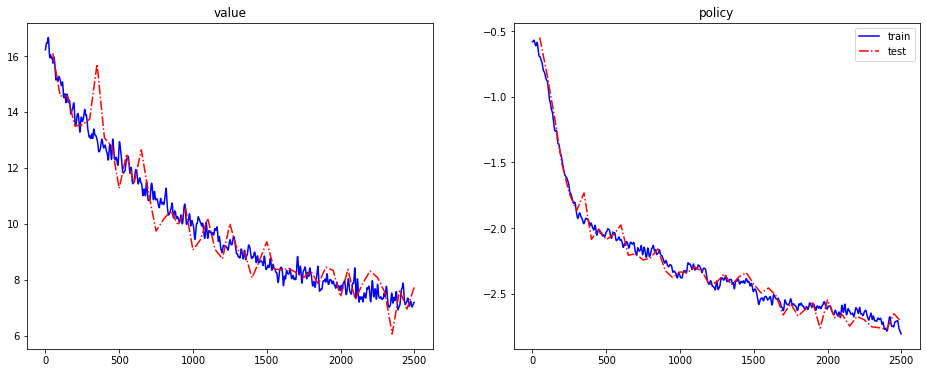

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = ddpg.update(batch, learn=True)
            plotter.log_losses(loss)
            ddpg.step()
            if ddpg._step % plot_every == 0:
                clear_output(True)
                print('step', ddpg._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if ddpg._step > 2500:
                return
            
learn()

## Ranking

In [28]:
! gdown https://drive.google.com/uc?id=1mpmflTtlpg8iTq4hX4k5AtsSr1mWHrJu
! unzip parsed.zip
clear_output()

In [29]:
meta = json.load(open('parsed/omdb.json'))

In [123]:
frame_size = 10
batch_size = 1
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

In [124]:
test_batch = next(iter(env.test_dataloader))
state, action, reward, next_state, done = recnn.data.get_base_batch(test_batch)

In [ ]:
def rank(gen_action, metric):
    scores = []
    for i in env.base.key_to_id.keys():
        if i == 0 or i == '0':
            continue
        scores.append([i, metric(env.base.embeddings[env.base.key_to_id[i]], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    for i in range(10):
        scores[i].extend([meta[str(scores[i][0])]['omdb'][key]  for key in ['Title',
                                'Genre', 'Language', 'Released', 'imdbRating']])
        
    indexes = ['id', 'score', 'Title', 'Genre', 'Language', 'Released', 'imdbRating']
    table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
    table = pd.DataFrame(table_dict)
    return table

In [125]:
ddpg_action = policy_net(state.to(cuda))
# pick random action
ddpg_action = ddpg_action[np.random.randint(0, state.size(0), 1)[0]].detach().cpu().numpy()

In [126]:
rank(ddpg_action, distance.euclidean)

,id,score,Title,Genre,Language,Released,imdbRating
0,1232,45.771500,Stalker,"Drama, Sci-Fi",Russian,17 Apr 1980,8.1
1,113565,46.087662,The Sacrament,"Horror, Thriller",English,01 May 2014,6.1
2,3701,46.331703,Alien Nation,"Action, Sci-Fi",English,07 Oct 1988,6.3
3,26464,46.463390,Blue Thunder,"Action, Crime, Drama, Sci-Fi, Thriller",English,13 May 1983,6.4
4,51562,46.577862,Babylon 5: The Gathering,"Action, Adventure, Drama, Mystery, Sci-Fi",English,22 Feb 1993,6.5
5,127244,46.686214,My Sweet Pepper Land,Drama,"Kurdish, Arabic, Turkish",27 Mar 2014,7.0
6,114700,46.842598,The Tribe,"Crime, Drama","Ukrainian Sign Language, Ukrainian",11 Sep 2014,7.0
7,3385,46.857498,Volunteers,Comedy,English,16 Aug 1985,5.5
8,31702,46.899803,Turtles Can Fly,"Drama, War","Kurdish, Arabic, English",23 Feb 2005,8.1
9,91707,46.927162,In the Land of Blood and Honey,"Drama, Romance, War","Bosnian, Serbian, Croatian, English",16 Feb 2012,4.5


In [129]:
rank(ddpg_action, distance.cityblock)

,id,score,Title,Genre,Language,Released,imdbRating
0,113565,401.094116,The Sacrament,"Horror, Thriller",English,01 May 2014,6.1
1,51562,408.559296,Babylon 5: The Gathering,"Action, Adventure, Drama, Mystery, Sci-Fi",English,22 Feb 1993,6.5
2,1232,409.049011,Stalker,"Drama, Sci-Fi",Russian,17 Apr 1980,8.1
3,3701,415.180511,Alien Nation,"Action, Sci-Fi",English,07 Oct 1988,6.3
4,67073,417.383728,Day of the Dead,"Action, Horror, Thriller",English,08 Apr 2008,4.5
5,82095,417.832947,Skyline,"Action, Sci-Fi, Thriller",English,12 Nov 2010,4.4
6,98200,418.209869,The Strawberry Statement,"Drama, Romance",English,14 Jun 1970,6.7
7,26464,418.516815,Blue Thunder,"Action, Crime, Drama, Sci-Fi, Thriller",English,13 May 1983,6.4
8,1848,419.351868,The Borrowers,"Adventure, Comedy, Family, Fantasy",English,13 Feb 1998,5.8
9,47810,419.657532,The Wicker Man,"Horror, Mystery, Thriller",English,01 Sep 2006,3.7


In [127]:
rank(ddpg_action, distance.cosine)

,id,score,Title,Genre,Language,Released,imdbRating
0,1232,0.667740,Stalker,"Drama, Sci-Fi",Russian,17 Apr 1980,8.1
1,3701,0.699166,Alien Nation,"Action, Sci-Fi",English,07 Oct 1988,6.3
2,113565,0.703103,The Sacrament,"Horror, Thriller",English,01 May 2014,6.1
3,26464,0.703409,Blue Thunder,"Action, Crime, Drama, Sci-Fi, Thriller",English,13 May 1983,6.4
4,51562,0.708594,Babylon 5: The Gathering,"Action, Adventure, Drama, Mystery, Sci-Fi",English,22 Feb 1993,6.5
5,130848,0.731977,Pas son genre,"Drama, Romance",French,30 Apr 2014,6.5
6,127244,0.732150,My Sweet Pepper Land,Drama,"Kurdish, Arabic, Turkish",27 Mar 2014,7.0
7,114700,0.737214,The Tribe,"Crime, Drama","Ukrainian Sign Language, Ukrainian",11 Sep 2014,7.0
8,31702,0.738288,Turtles Can Fly,"Drama, War","Kurdish, Arabic, English",23 Feb 2005,8.1
9,36363,0.738782,Kin-dza-dza!,"Comedy, Drama, Sci-Fi","Georgian, Russian",01 Dec 1986,8.2


In [128]:
rank(ddpg_action, distance.correlation)

,id,score,Title,Genre,Language,Released,imdbRating
0,1232,0.658527,Stalker,"Drama, Sci-Fi",Russian,17 Apr 1980,8.1
1,3701,0.698065,Alien Nation,"Action, Sci-Fi",English,07 Oct 1988,6.3
2,113565,0.701502,The Sacrament,"Horror, Thriller",English,01 May 2014,6.1
3,26464,0.702226,Blue Thunder,"Action, Crime, Drama, Sci-Fi, Thriller",English,13 May 1983,6.4
4,51562,0.705251,Babylon 5: The Gathering,"Action, Adventure, Drama, Mystery, Sci-Fi",English,22 Feb 1993,6.5
5,130848,0.713697,Pas son genre,"Drama, Romance",French,30 Apr 2014,6.5
6,36363,0.734956,Kin-dza-dza!,"Comedy, Drama, Sci-Fi","Georgian, Russian",01 Dec 1986,8.2
7,67073,0.735403,Day of the Dead,"Action, Horror, Thriller",English,08 Apr 2008,4.5
8,127244,0.736384,My Sweet Pepper Land,Drama,"Kurdish, Arabic, Turkish",27 Mar 2014,7.0
9,848,0.741282,The Spitfire Grill,Drama,English,06 Sep 1996,7.0
